In [1]:
import os
import warnings
import datetime
import unidecode
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

from github import Github
from matplotlib import pyplot, colors

import sklearn.linear_model

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

pyplot.rcParams['figure.figsize'] = [60/2.54, 36/2.54]

In [2]:
git = Github(os.getenv('GH_TOKEN'))
repo = git.get_repo('pr0nstar/covid19-data')

In [3]:
muni_data = pd.read_csv('../update/sdsn.gen.csv')
muni_data = muni_data.set_index('cod_ine')

In [4]:
def stylize_ax(ax, legend=True):
    if type(ax) == np.ndarray:
        [stylize_ax(_, legend) for _ in ax]
        return
    
    ax.grid(
        axis='both',
        which='both',
        color='DarkTurquoise', 
        alpha=0.2, 
        linestyle=':', 
        linewidth=2
    )
    
    if legend:
        ax.legend(loc='upper left')

### reportes diarios

In [5]:
reported_deaths_df = pd.read_csv(
    'https://github.com/mauforonda/covid19-bolivia-udape/raw/master/decesos_acumulados.csv',
    index_col=0
)

reported_deaths_df.index = pd.to_datetime(reported_deaths_df.index)
reported_deaths_df = reported_deaths_df.sort_index()

reported_deaths_df.columns = [
    unidecode.unidecode(_).lower().replace(' ', '.') for _ in reported_deaths_df.columns
]


In [6]:
for _ in range(3):
    reported_deaths_df[(reported_deaths_df.diff() < 0).shift(-1).fillna(False)] = np.nan
    reported_deaths_df = reported_deaths_df.interpolate('from_derivatives', limit_area='inside')

for _ in range(3):
    reported_deaths_df[reported_deaths_df.diff() < 0] = np.nan
    reported_deaths_df = reported_deaths_df.interpolate('from_derivatives', limit_area='inside')

In [7]:
reported_deaths_df = reported_deaths_df.round()

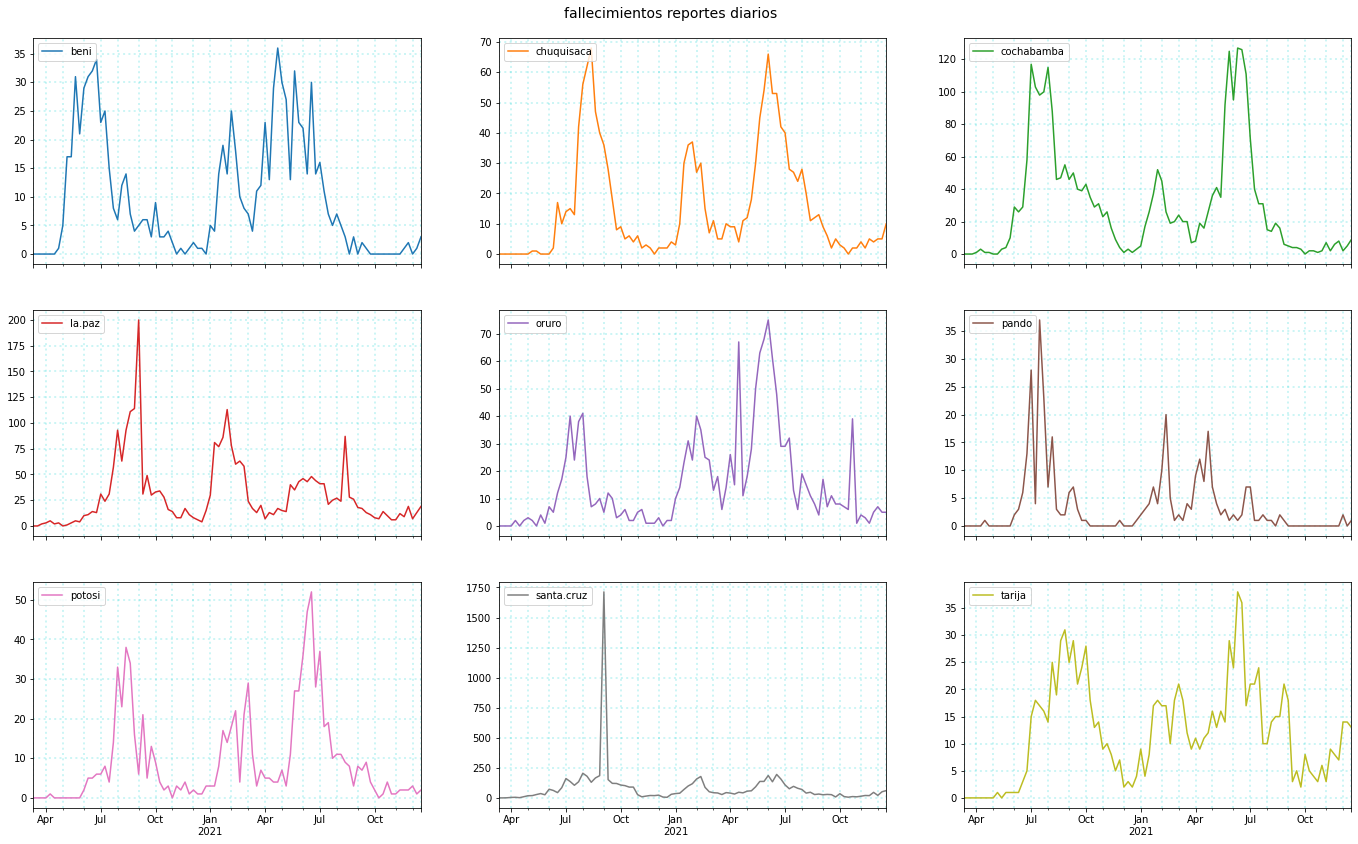

In [8]:
axs = reported_deaths_df[sorted(reported_deaths_df.columns)].diff().resample('W').sum().plot(
    subplots=True, layout=(3, 3)
)

axs[0][1].get_figure().suptitle('fallecimientos reportes diarios', y=.91, fontsize=14)
stylize_ax(axs)

### siahv covid

In [9]:
def read_df(file_name):
    df = pd.read_csv(file_name, header=None)
    df.iloc[0] = pd.to_datetime(df.iloc[0])

    df.columns = pd.MultiIndex.from_frame(df.iloc[:3].T)
    df = df.iloc[3:]

    df.index = pd.MultiIndex.from_frame(df.iloc[:, :3])
    df.index.names = ['departamento', 'municipio', 'edad']
    df = df.iloc[:, 3:]

    df.columns = df.columns.droplevel(2)
    df = df.astype(int)
    
    return df

In [10]:
dept_paths = repo.get_contents('raw/bolivia/snis/siahv/covid')
dept_paths = [_ for _ in dept_paths if _.path.endswith('.csv')]

In [11]:
siahv_dept_data = {}

for file_name in dept_paths:
    df = read_df(file_name.download_url)
    df_name = os.path.basename(file_name.path).split('.')[0]
    df_name = pd.to_datetime(df_name)
    
    for dept_name in df.index.get_level_values(0).unique():
        dept_df = df.loc[dept_name].groupby(level=1).sum()
        dept_df = dept_df.groupby(level=0, axis=1).sum().sum()
        
        dept_df.name = df_name
        dept_df.index = pd.to_datetime(dept_df.index)
        
        siahv_dept_data[dept_name] = pd.concat([
            siahv_dept_data.get(dept_name, pd.DataFrame([])),
            dept_df
        ], axis=1)

In [12]:
for dept in siahv_dept_data.keys():
    siahv_dept = siahv_dept_data[dept]
    siahv_dept.index = pd.to_datetime(siahv_dept.index)
    siahv_dept_data[dept] = siahv_dept

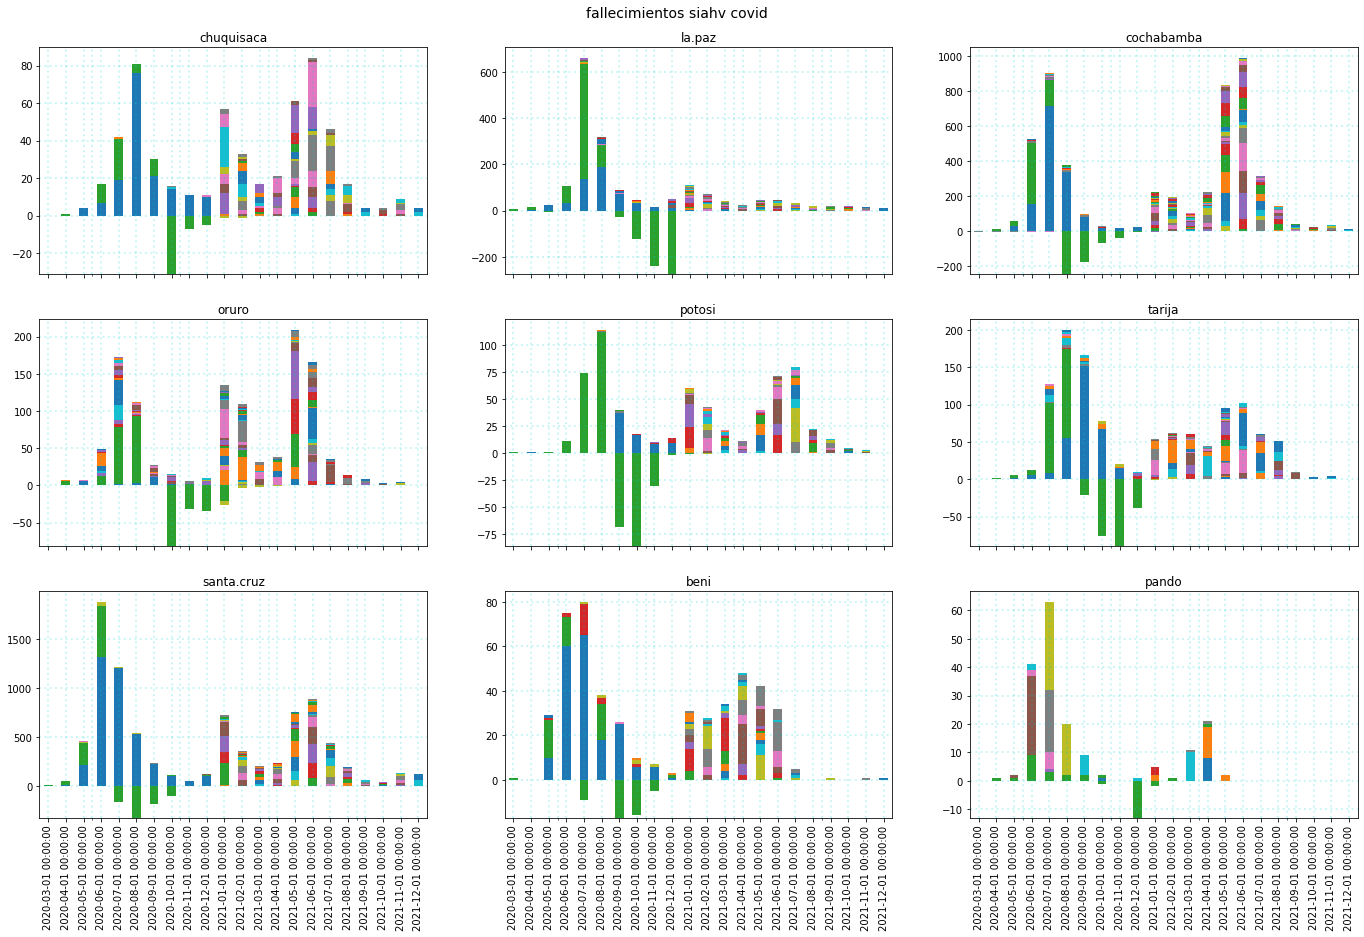

In [13]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_dept = siahv_dept_data[dept]
    siahv_dept = siahv_dept.T.fillna(0).diff().fillna(siahv_dept.T)
    
    siahv_dept.iloc[0] = siahv_dept.iloc[0] + siahv_dept[siahv_dept < -10].sum()
    siahv_dept = siahv_dept.resample('W').sum().T
    
    siahv_dept.plot(
        ax=axs[idx], kind='bar', stacked=True, legend=None
    )
    axs[idx].set_title(dept)
    
fig.suptitle('fallecimientos siahv covid', y=.92, fontsize=14)
stylize_ax(axs, legend=False)

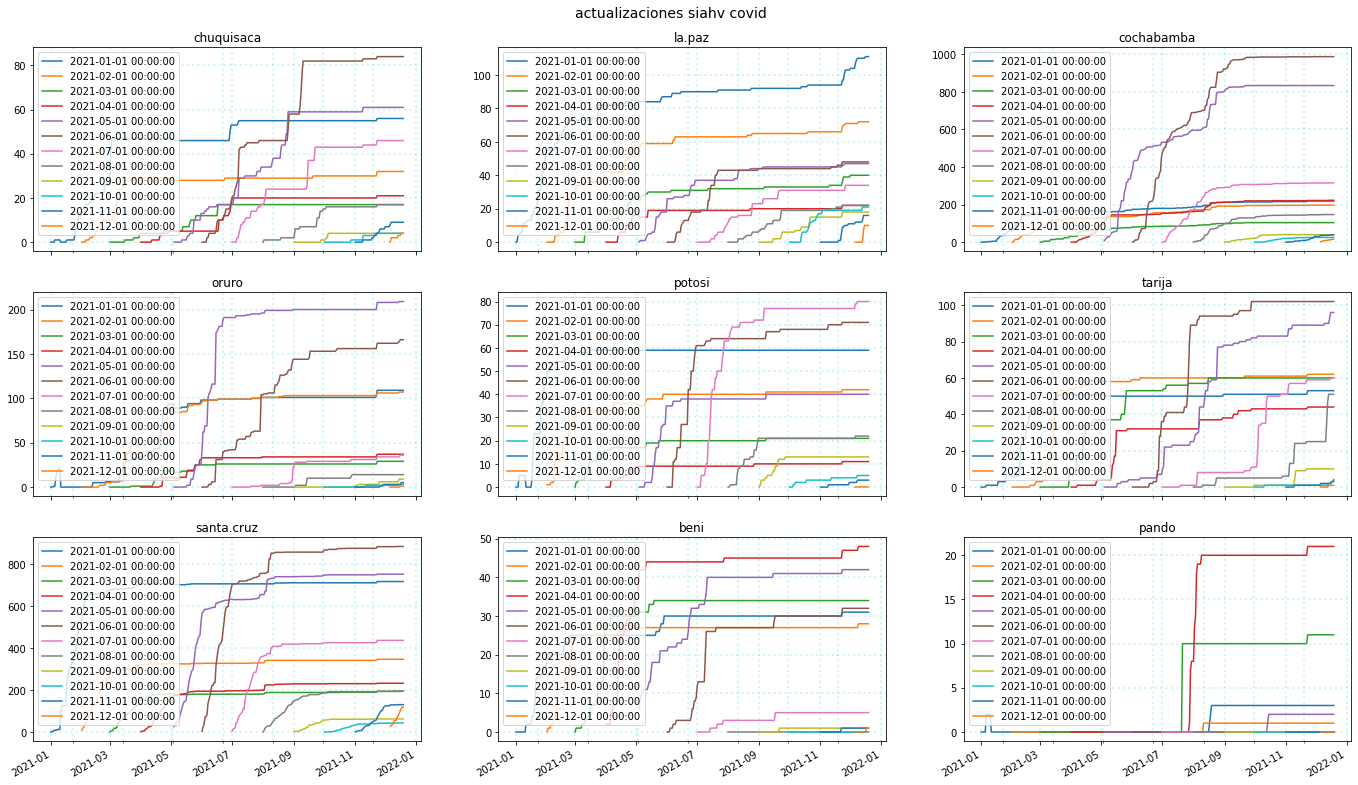

In [14]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_dept = siahv_dept_data[dept]
    
    siahv_dept.loc['2021-01-01':].T.plot(ax=axs[idx])
    axs[idx].set_title(dept)
    
fig.suptitle('actualizaciones siahv covid', y=.92, fontsize=14)
stylize_ax(axs)

In [15]:
siahv_dept_latest = read_df(dept_paths[-1].download_url)
siahv_dept_latest.groupby(level=0).sum().sum(axis=1)

departamento
beni           478
chuquisaca     556
cochabamba    5186
la.paz        1791
oruro         1132
pando          176
potosi         653
santa.cruz    8764
tarija        1174
dtype: int64

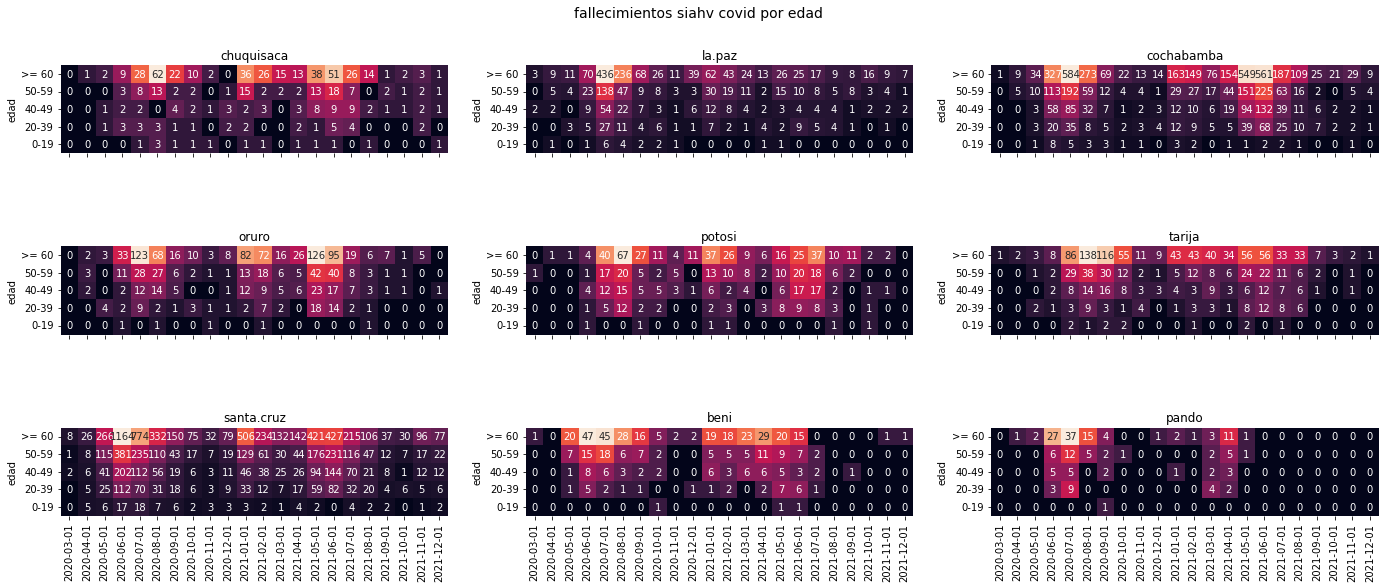

In [16]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, figsize=(60/2.54, 24/2.54), sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):

    siahv_by_age = siahv_dept_latest.loc[dept].groupby(level=1).sum()
    siahv_by_age = siahv_by_age.groupby(level=0, axis=1).sum()
    
    siahv_by_age = siahv_by_age.loc[siahv_by_age.index[::-1]]
    siahv_by_age.columns = [str(_)[:10] for _ in siahv_by_age.columns]
    
    sns.heatmap(
        siahv_by_age,
        annot=True,
        fmt=".0f",
        square=True,
        norm=colors.PowerNorm(.5),
        cbar=False,
        ax=axs[idx],
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos siahv covid por edad', y=.92, fontsize=14)

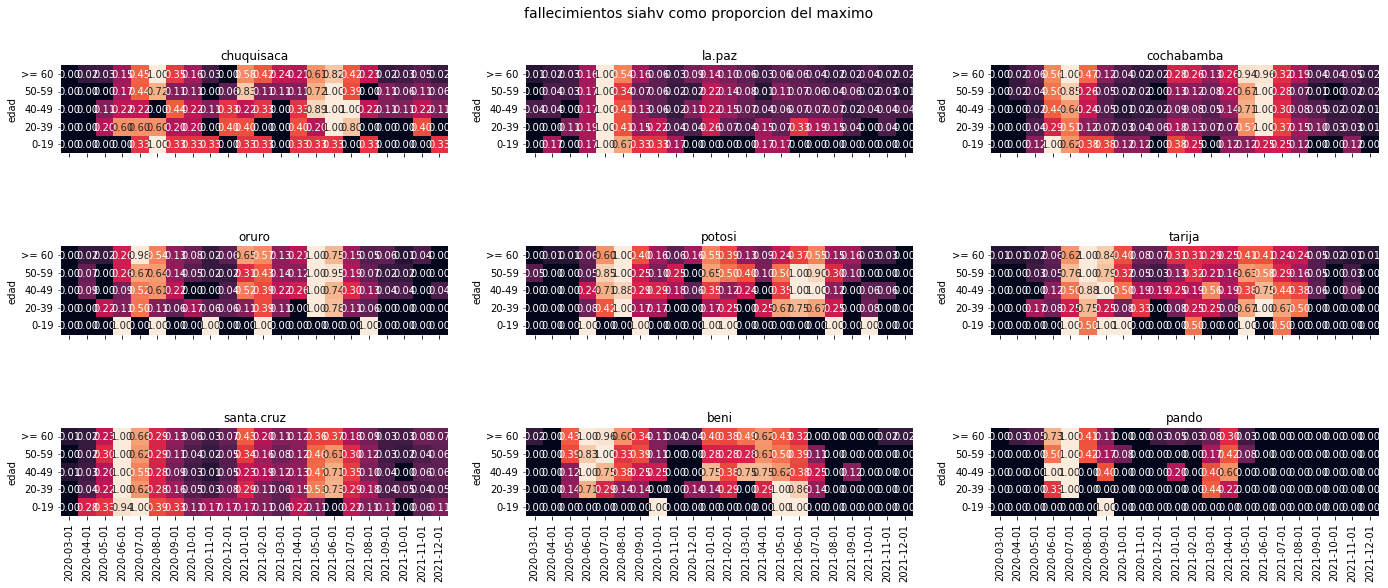

In [17]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, figsize=(60/2.54, 24/2.54), sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_by_age = siahv_dept_latest.loc[dept].groupby(level=1).sum()
    siahv_by_age = siahv_by_age.groupby(level=0, axis=1).sum()
    
    siahv_by_age = siahv_by_age.T / siahv_by_age.max(axis=1)
    siahv_by_age = siahv_by_age.round(2).T
    
    siahv_by_age = siahv_by_age.loc[siahv_by_age.index[::-1]]
    siahv_by_age.columns = [str(_)[:10] for _ in siahv_by_age.columns]

    sns.heatmap(
        siahv_by_age,
        annot=True,
        fmt=".2f",
        square=True,
        norm=colors.PowerNorm(.5),
        cbar=False,
        ax=axs[idx],
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos siahv como proporcion del maximo', y=.92, fontsize=14)

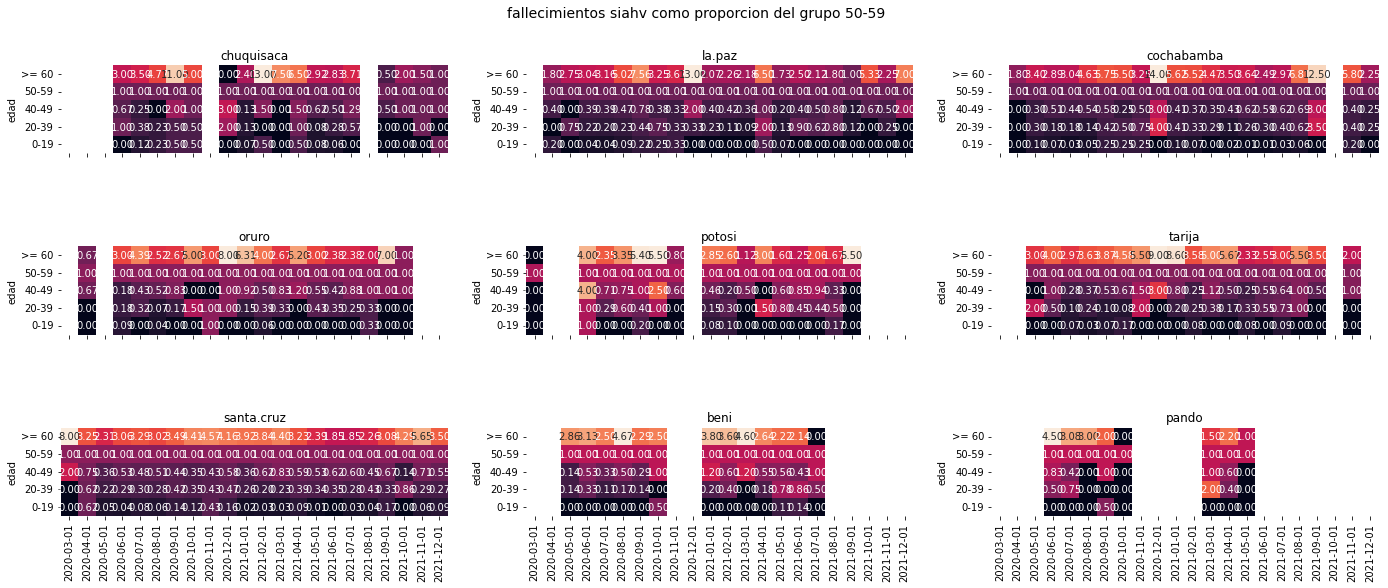

In [18]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, figsize=(60/2.54, 24/2.54), sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(siahv_dept_data.keys()):
    siahv_by_age = siahv_dept_latest.loc[dept].groupby(level=1).sum()
    siahv_by_age = siahv_by_age.groupby(level=0, axis=1).sum()
    
    siahv_by_age = siahv_by_age / siahv_by_age.loc['50-59']
    siahv_by_age = siahv_by_age.round(2)
    
    siahv_by_age = siahv_by_age.loc[siahv_by_age.index[::-1]]
    siahv_by_age.columns = [str(_)[:10] for _ in siahv_by_age.columns]

    sns.heatmap(
        siahv_by_age,
        annot=True,
        fmt=".2f",
        square=True,
        norm=colors.PowerNorm(.5),
        cbar=False,
        ax=axs[idx],
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos siahv como proporcion del grupo 50-59 ', y=.92, fontsize=14)

### snis

In [19]:
AGE_MAP = {
    '0-19': ['a', 'b', 'c', 'd', 'e', 'f'],
    '20-39': ['g'],
    '40-49': ['h'],
    '50-59': ['i'],
    '>= 60': ['j']
}
CAT_AGE_MAP = dict(itertools.chain(*[
    itertools.product(v,(k,)) for k,v in AGE_MAP.items()
]))

def clean_df(df):
    data_df = df.loc[5:]
    data_df = data_df.loc[:, ~data_df.T.isna().T.all(axis=0)]
    data_df = data_df[~data_df.iloc[:, 2].isna()]

    data_df = data_df.iloc[:, 1:-2]
    data_df = data_df.T.reset_index(drop=True).T.reset_index(drop=True)

    data_df[0] = data_df[0].fillna(method='ffill')
    data_df = data_df.fillna(0)

    return data_df

def format_df(df):
    data_df = pd.DataFrame([])

    for muni, muni_df in df.groupby(0):
        muni_df = muni_df.set_index(1)
        fixed_df = pd.DataFrame([])

        for age, age_df in muni_df.groupby(lambda _: CAT_AGE_MAP[_[0]]):
            fixed_df[age] = age_df.iloc[:, 1:].sum(axis=0).reset_index(drop=True)

        fixed_df.columns = pd.MultiIndex.from_product([[muni], fixed_df.columns])
        data_df = pd.concat([data_df, fixed_df], axis=1)

    data_df.index = pd.MultiIndex.from_product([
        np.arange(len(data_df) / 2, dtype=int) + 1, ['Hombres', 'Mujeres']
    ])
    data_df = data_df.unstack()
    data_df.index = pd.to_datetime(
            data_df.index, unit='W', origin=pd.Timestamp('{}-01-01'.format(year))
    )

    return data_df

In [20]:
snis_dept_data = {}
year_paths = repo.get_contents('raw/bolivia/snis/estadisticas.reportes_dinamicos/mortalidad')

for year_dirname in year_paths:
    year = os.path.basename(year_dirname.path)
    
    dept_paths = repo.get_contents(year_dirname.path)
    dept_paths = [_ for _ in dept_paths if _.path.endswith('.xls') or _.path.endswith('.xlsx')]
    
    for file_name in dept_paths:
        dept_name = os.path.basename(file_name.path).rsplit('.', 1)[0]
        
        df = pd.read_excel(file_name.download_url, header=None)
        df = clean_df(df)
        df = format_df(df)
        
        dept_data = snis_dept_data.get(dept_name, {})
        dept_data[year] = df
        snis_dept_data[dept_name] = dept_data

WARNING *** file size (237270) not 512 + multiple of sector size (512)
WARNING *** file size (347851) not 512 + multiple of sector size (512)
WARNING *** file size (625792) not 512 + multiple of sector size (512)
WARNING *** file size (1028007) not 512 + multiple of sector size (512)
WARNING *** file size (222375) not 512 + multiple of sector size (512)
WARNING *** file size (98163) not 512 + multiple of sector size (512)
WARNING *** file size (403291) not 512 + multiple of sector size (512)
WARNING *** file size (727013) not 512 + multiple of sector size (512)
WARNING *** file size (143367) not 512 + multiple of sector size (512)
WARNING *** file size (209267) not 512 + multiple of sector size (512)
WARNING *** file size (319655) not 512 + multiple of sector size (512)
WARNING *** file size (525131) not 512 + multiple of sector size (512)
WARNING *** file size (877860) not 512 + multiple of sector size (512)
WARNING *** file size (196667) not 512 + multiple of sector size (512)
WARNIN

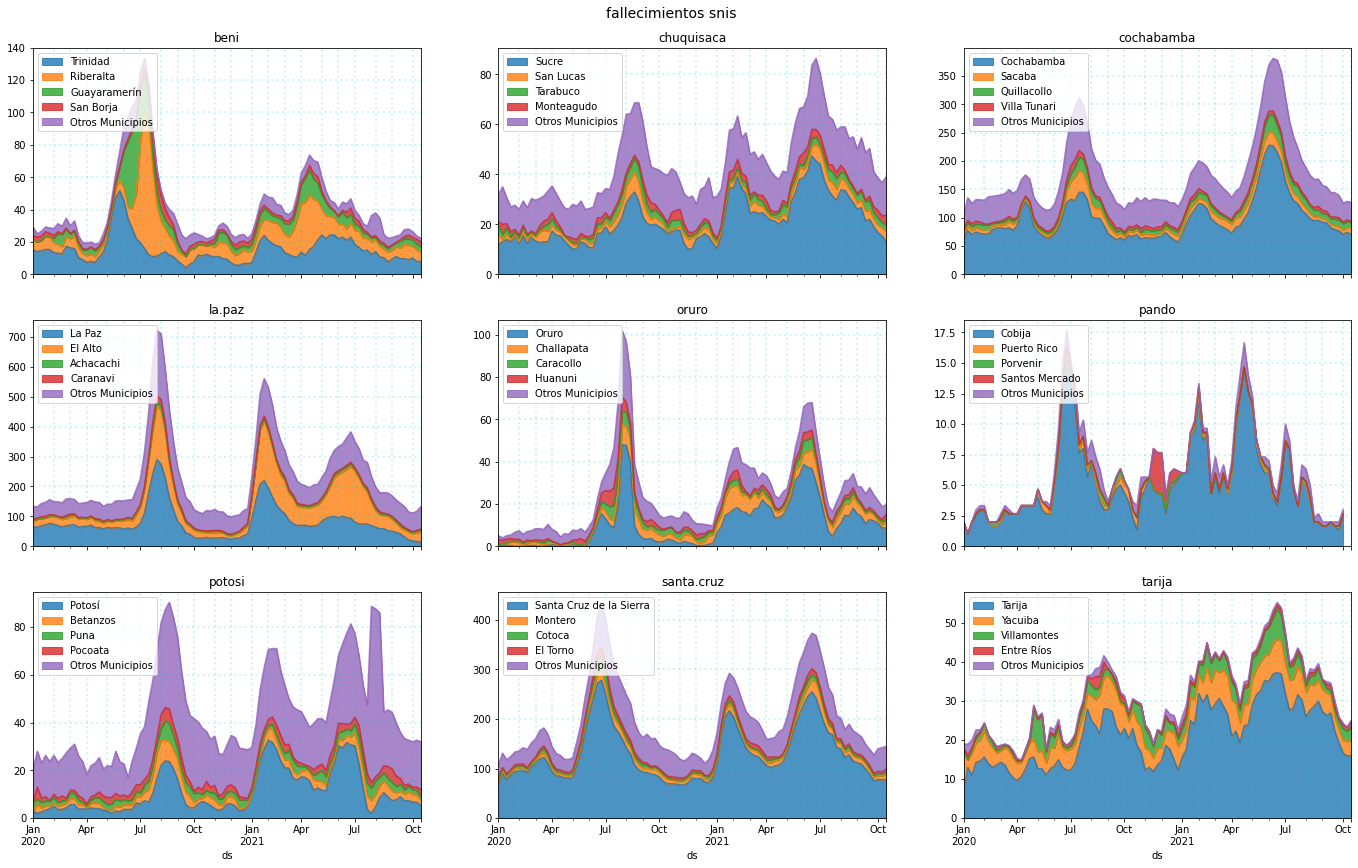

In [21]:
fig, axs = pyplot.subplots(ncols=3, nrows=3, sharex=True)
axs = axs.flatten()

for idx, dept in enumerate(snis_dept_data.keys()):
    dept_df = snis_dept_data[dept]
    dept_df = pd.concat(dept_df.values()).sort_index()
    dept_df.index = dept_df.index.rename('ds')

    dept_df = dept_df.T.groupby(level=0).sum().T.copy()
    dept_df.columns = dept_df.columns.astype(np.int64)
    
    dept_df = dept_df.loc['2020':]
    dept_df = dept_df.iloc[:-1]
    idx_df = dept_df.sum().sort_values(ascending=False)
    
    dept_plot_df = dept_df[idx_df[:4].index].copy()
    dept_plot_df = dept_plot_df.rename(columns=muni_data['municipio'])
    if len(idx_df) > 4:
        rest_df = dept_df[idx_df[4:].index].sum(axis=1)
        dept_plot_df['Otros Municipios'] = rest_df
        
    dept_plot_df.rolling(window=3).mean().fillna(dept_plot_df).plot(
        title=dept, kind='area', alpha=.8, ax=axs[idx]
    )

_ = fig.suptitle('fallecimientos snis', y=.92, fontsize=14)
stylize_ax(axs)

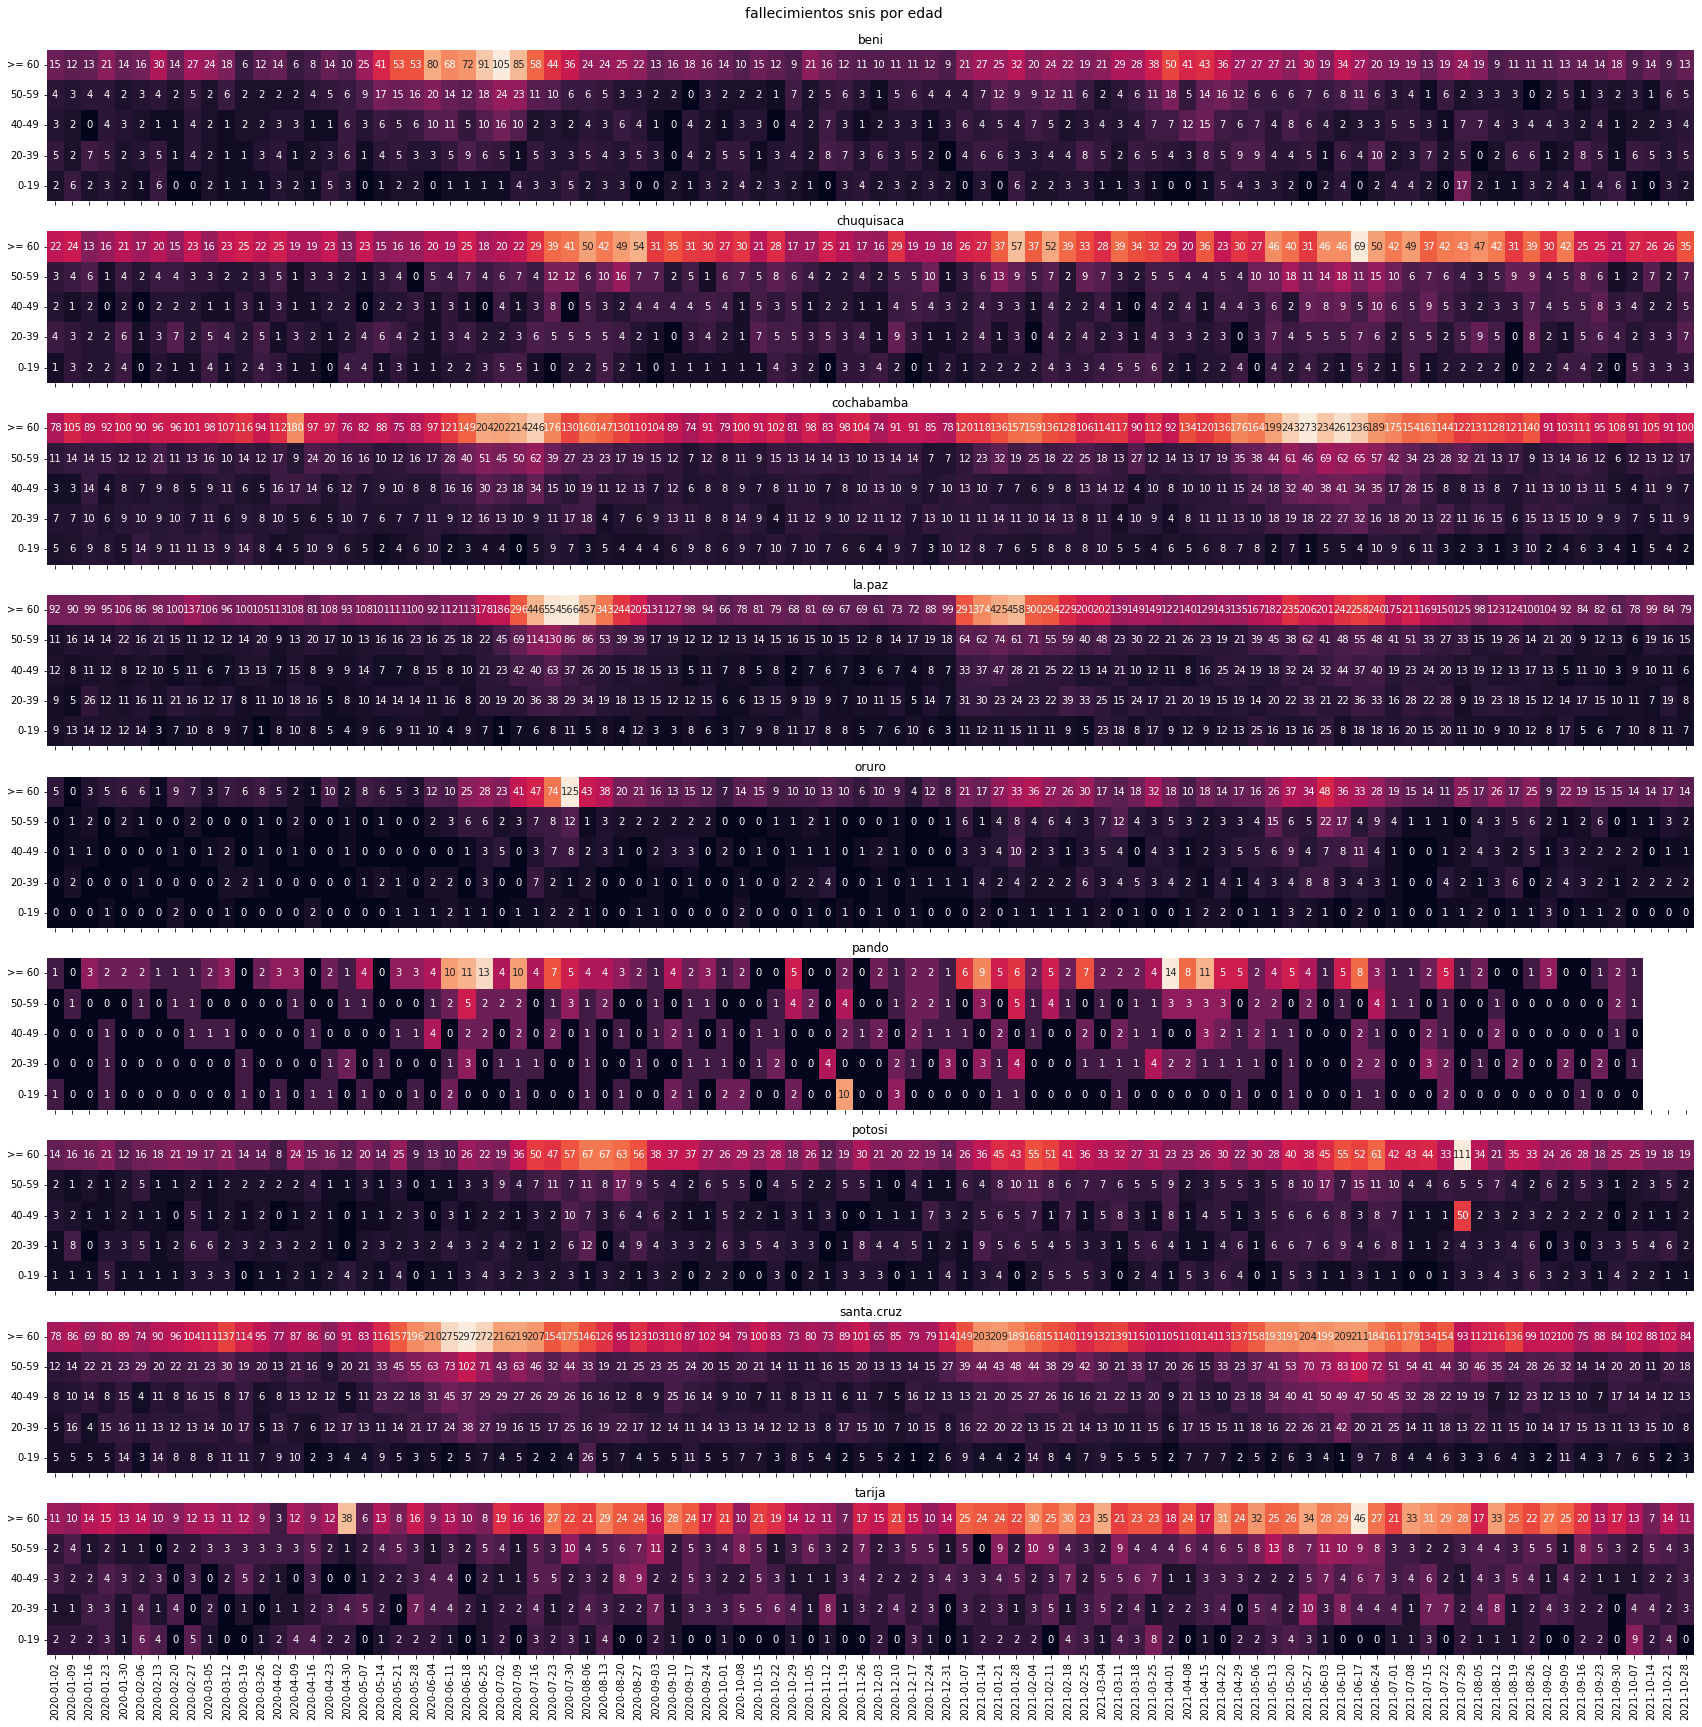

In [22]:
fig, axs = pyplot.subplots(figsize=(75/2.54, 75/2.54), ncols=1, nrows=9, sharex=True)

for idx, dept in enumerate(snis_dept_data.keys()):
    dept_df = snis_dept_data[dept]
    dept_df = pd.concat([dept_df['2020'], dept_df['2021']]).sort_index()
    dept_df.index = dept_df.index.rename('ds')
    
    by_age = dept_df.groupby(level=1, axis=1).sum().T
    by_age = by_age.loc[by_age.index[::-1]]
    by_age.columns = [str(_)[:10] for _ in by_age.columns]

    sns.heatmap(
        by_age,
        annot=True,
        fmt=".0f",
        norm=colors.PowerNorm(.66),
        ax=axs[idx],
        cbar=False
    )
    axs[idx].set_title(dept)
    
_ = fig.suptitle('fallecimientos snis por edad', y=.9, fontsize=14)

### sereci

In [23]:
sereci_dir = repo.get_contents('raw/bolivia/sereci')
sereci_file = {
    os.path.basename(_.path): _ for _ in sereci_dir
}['sereci.by.death.date.csv']

In [24]:
sereci_df = pd.read_csv(sereci_file.download_url, index_col=0)
sereci_df.index = pd.to_datetime(sereci_df.index)

sereci_df.columns = [_.lower().replace(' ', '.') for _ in sereci_df.columns]
sereci_df = sereci_df[sorted(sereci_df.columns)]

sereci_df.tail(5)

,beni,chuquisaca,cochabamba,la.paz,oruro,pando,potosi,santa.cruz,tarija
2021-05-01,257,397,2006,2041,648,33,466,2144,345
2021-06-01,230,510,2377,2634,672,23,705,2443,348
2021-07-01,223,550,1433,2330,375,26,663,1953,367
2021-08-01,183,419,1117,1913,348,18,545,1497,338
2021-09-01,182,310,976,1640,323,22,428,1242,272


In [25]:
def resample_monthly(df, method='from_derivatives', **kwargs):
    df = df.copy()
    
    df_index = df.iloc[-1:].resample('W').mean().index
    df_index_diff = (
        (df_index + pd.offsets.MonthBegin(1)) - df_index
    )
    df_index_diff = np.floor(
        df_index_diff / pd.Timedelta(days=7)
    )[0] * 7 + df_index.day[0] - 1

    df_index = df.index[0]
    df.index = df.index + pd.DateOffset(
        days=df_index_diff
    )

    df.loc[
        pd.to_datetime(df_index) - pd.DateOffset(days=1)
    ] = 0
    df = df.sort_index()

    df = df.cumsum().asfreq('d')
    df = df.interpolate(method, **kwargs)
    
    df = df.diff().dropna().resample('W').sum()
    df = df.round()
    
    return df

In [26]:
resample_sereci_df = resample_monthly(sereci_df)

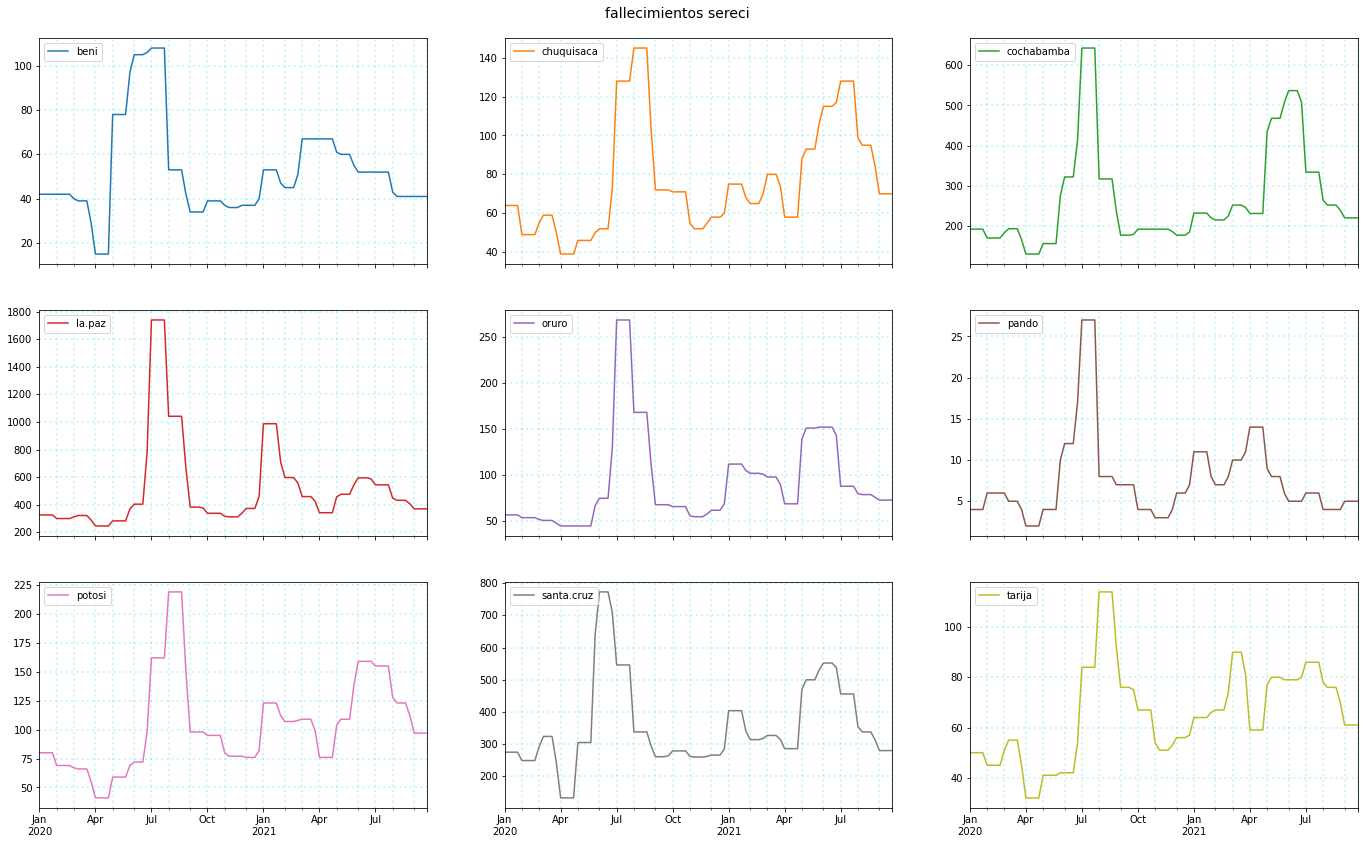

In [27]:
axs = resample_sereci_df['2020':].plot(
    subplots=True, layout=(3, 3)
)

axs[0][0].get_figure().suptitle('fallecimientos sereci', y=.91, fontsize=14)
stylize_ax(axs)

### Comparativo

In [28]:
def year_start(year):
    fourth_jan = datetime.date(year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday() - 1)
    
    return fourth_jan - delta

def align_precovid(df):
    # https://github.com/dkobak/excess-mortality/blob/main/all-countries.ipynb
    base_df = df.loc[:'2019']
    base_df_index = base_df.index.isocalendar()
    
    base_df = base_df.to_frame().set_index([
        base_df_index.year, base_df_index.week
    ])[df.name]
    base_df = base_df[~base_df.index.duplicated(keep='last')]
    base_df = base_df.unstack(level=0).loc[:52].T.stack()
    
    base_years = base_df.index.get_level_values(0).values.reshape(-1 ,1)
    base_years_n = len(np.unique(base_years))

    onehot = np.concatenate([np.eye(52) for _ in range(base_years_n)])
    predictors = np.concatenate((base_years, onehot), axis=1)

    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(
        predictors, base_df.values
    )

    baseline = reg.predict(
        np.concatenate((np.ones((52, 1)) * 2020, np.eye(52)), axis=1)
    )
    
    fbase_df = pd.DataFrame([])
    for year in df.loc['2020':].index.year.unique():
        indexed_base_df = pd.Series(baseline)
        base_df_index = pd.date_range(
            start=year_start(year) + datetime.timedelta(1), 
            end=year_start(year + 1), 
            freq='W'
        )
        if len(base_df_index) == 53:
            indexed_base_df.loc[53] = indexed_base_df.iloc[-1]
            
        indexed_base_df.index = base_df_index
        fbase_df = pd.concat([fbase_df, indexed_base_df])
        
    return fbase_df[0].rename(df.name)[:df.index[-1]]

In [29]:
snis_mortality_df = pd.concat([
    pd.concat([__ for __ in _.values()]) for _ in snis_dept_data.values()
], axis=1)
snis_mortality_df = snis_mortality_df[~snis_mortality_df.index.duplicated(keep='last')]

snis_mortality_df.index = snis_mortality_df.index + pd.Timedelta(days=3)

snis_mortality_df = snis_mortality_df.groupby(level=0, axis=1).sum(min_count=1)
snis_mortality_df = snis_mortality_df.groupby(lambda _: str(_)[0], axis=1).sum(min_count=1)

In [30]:
muni_data_name = muni_data.groupby(
    lambda _: str(_)[0]
)['departamento'].unique()
muni_data_name = muni_data_name.apply(
    lambda _: unidecode.unidecode(_[0]).lower().replace(' ', '.')
)

snis_mortality_df = snis_mortality_df.rename(muni_data_name, axis=1)

In [31]:
snis_bases_df = snis_mortality_df.iloc[:, :-1].apply(align_precovid)
snis_bases_df.loc[:, 'cochabamba'] = align_precovid(snis_mortality_df.loc['2019':, 'cochabamba'])
snis_bases_df.loc[:, 'pando'] = snis_mortality_df.loc['2020':'2020-03-31', 'pando'].mean()

snis_bases_df = snis_bases_df.round(1)

In [32]:
sereci_bases_df = resample_sereci_df.apply(align_precovid)
sereci_bases_df = sereci_bases_df.round()

In [33]:
def stylize_comparison(axs, loc='upper right'):
    for idx, ax in enumerate(axs):
        ax.set_title(sorted(reported_deaths_df.columns)[idx])
        ax.legend(
            ax.get_lines(), 
            ['snis', 'sereci', 'siahv covid', 'reportes diarios'], 
            loc=loc
        )
        ax.grid(
            axis='both',
            which='both',
            color='DarkTurquoise', 
            alpha=0.2, 
            linestyle=':', 
            linewidth=2
        )

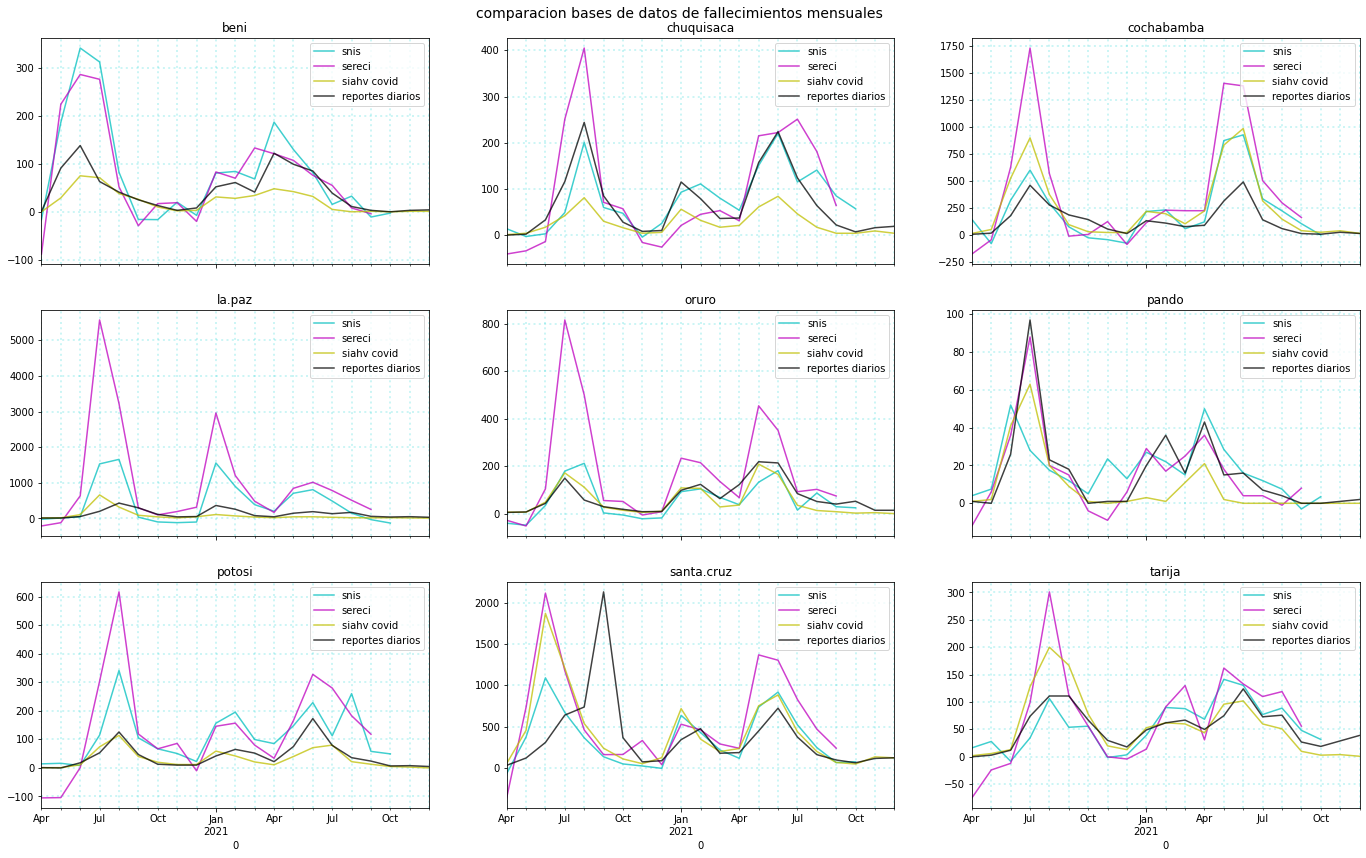

In [34]:
snis_dept_total_plot = snis_mortality_df['2020-04-01':] - snis_bases_df
snis_dept_total_plot = snis_dept_total_plot.dropna(how='all')[
    sorted(reported_deaths_df.columns)
].resample('M').sum()
axs = snis_dept_total_plot.plot(
    subplots=True, layout=(3, 3), color='c', alpha=.75
)
axs = axs.flatten()

sereci_df_plot = resample_sereci_df['2020-04-01':] - sereci_bases_df
sereci_df_plot = sereci_df_plot.dropna(how='all')[
    sorted(reported_deaths_df.columns)
].resample('M').sum()
axs = sereci_df_plot.plot(
    subplots=True, ax=axs, color='m', alpha=.75
)

siahv_dept_plot = siahv_dept_latest.groupby(level=0).sum()
siahv_dept_plot = siahv_dept_plot.groupby(level=0, axis=1).sum()
siahv_dept_plot = siahv_dept_plot.T[sorted(reported_deaths_df.columns)].loc['2020-04-01':]
axs = siahv_dept_plot.plot(
    subplots=True, ax=axs, color='y', alpha=.75
)

reported_df_plot = reported_deaths_df[
    sorted(reported_deaths_df.columns)
].diff().resample('M').sum()
reported_df_plot.index = reported_df_plot.index - pd.offsets.MonthBegin(1)
reported_df_plot = reported_df_plot.loc['2020-04':]

axs = reported_df_plot.plot(
    subplots=True, ax=axs, color='k', alpha=.75
)

axs[0].get_figure().suptitle(
    'comparacion bases de datos de fallecimientos mensuales', y=.91, fontsize=14
)
stylize_comparison(axs)

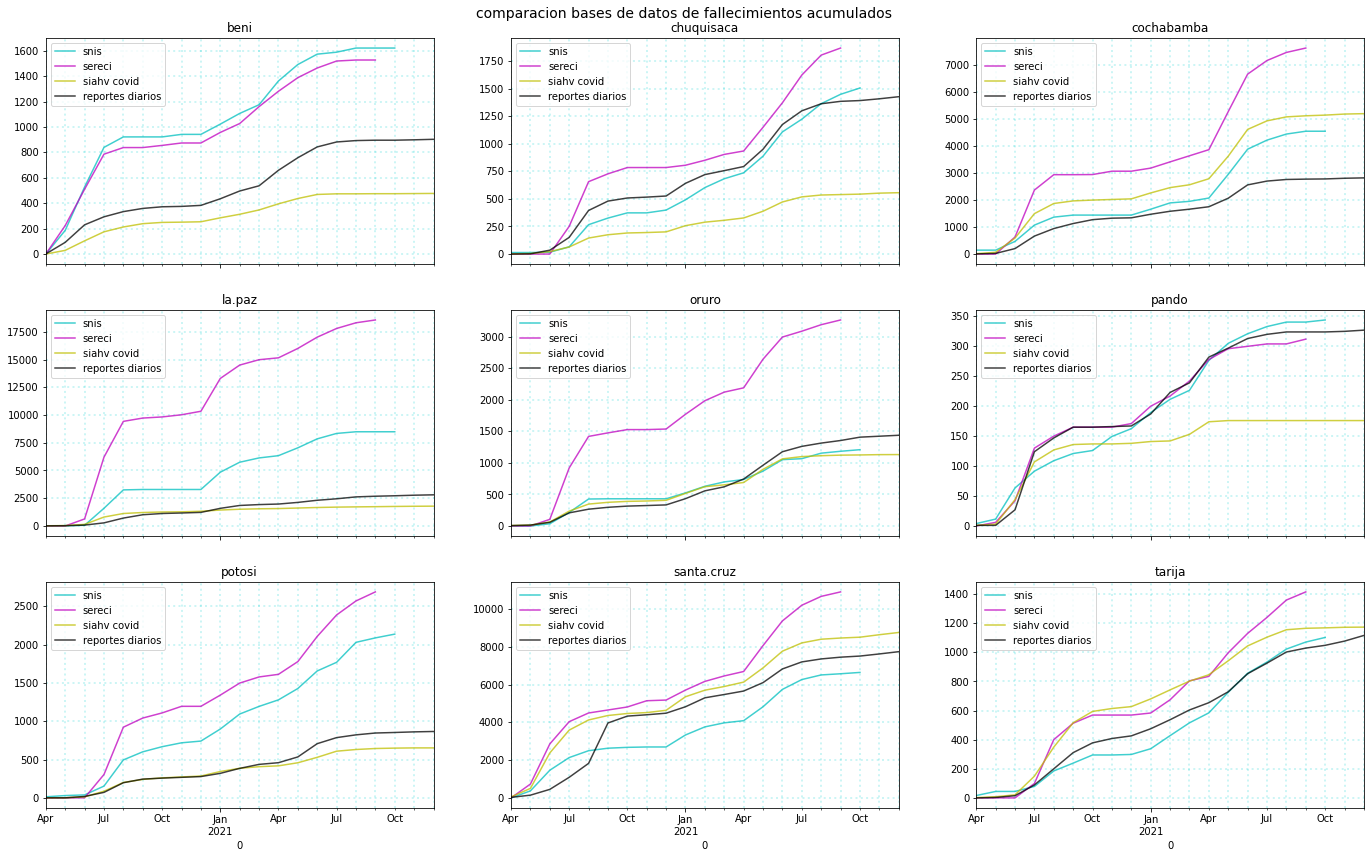

In [35]:
def do_cumsum(df):
    df = df.copy()
    df[df < 0] = 0
    
    return df.cumsum()

axs = do_cumsum(snis_dept_total_plot).plot(
    subplots=True, layout=(3, 3), color='c', alpha=.75
)
axs = axs.flatten()

axs = do_cumsum(sereci_df_plot).plot(
    subplots=True, ax=axs, color='m', alpha=.75
)

axs = do_cumsum(siahv_dept_plot).plot(
    subplots=True, ax=axs, color='y', alpha=.75
)

axs = do_cumsum(reported_df_plot).plot(
    subplots=True, ax=axs, color='k', alpha=.75
)

axs[0].get_figure().suptitle(
    'comparacion bases de datos de fallecimientos acumulados', y=.91, fontsize=14
)
stylize_comparison(axs, loc='upper left')